<a href="https://colab.research.google.com/github/Praagnya/testrep/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from PIL import Image
import tensorflow as tf
import keras
import os
import json
from typing import Tuple, Callable
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers
from keras.models import Sequential
from keras import backend as K
from keras import metrics
from keras.engine.training import Model
from keras import layers
from keras import models

In [2]:
# Get the GPU device name. 
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [3]:
#In order for torch to use the GPU, we need to identify and specify the GPU as the device.
if torch.cuda.is_available():
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:',torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [4]:
!unzip /content/drive/MyDrive/drive-download-20211007T070407Z-001.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Car Images/Test Images/._Chrysler PT Cruiser Convertible 2008  
  inflating: __MACOSX/Car Images/Test Images/._Hyundai Veracruz SUV 2012  
  inflating: __MACOSX/Car Images/Test Images/BMW M3 Coupe 2012/._04770.jpg  
  inflating: __MACOSX/Car Images/Test Images/._Chrysler Sebring Convertible 2010  
  inflating: __MACOSX/Car Images/Test Images/BMW M3 Coupe 2012/._04492.jpg  
  inflating: __MACOSX/Car Images/Test Images/._Ford F-450 Super Duty Crew Cab 2012  
  inflating: __MACOSX/Car Images/Test Images/._Ferrari 458 Italia Convertible 2012  
  inflating: __MACOSX/Car Images/Test Images/._Dodge Ram Pickup 3500 Crew Cab 2010  
  inflating: __MACOSX/Car Images/Test Images/._Chrysler Crossfire Convertible 2008  
  inflating: __MACOSX/Car Images/Test Images/._Chevrolet Tahoe Hybrid SUV 2012  
  inflating: __MACOSX/Car Images/Test Images/._Ford F-150 Regular Cab 2012  
  inflating: __MACOSX/Car Images/Test Images/._Fisker

In [5]:
def clean_file (file):

    car_df = pd.read_csv(file)
    car_df.columns = ['file','BBOX_x1','BBOX_y1','BBOX_x2','BBOX_y2', 'class']
    names_df = pd.read_csv('/content/Car names and make.csv', header= None)
    names_df.columns = ['model_name']
    name_list = []

    for i in range(len(car_df)):
        name = names_df['model_name'][car_df['class'][i] - 1]
        name_list.append(name)

    names = pd.DataFrame(name_list)
    names.columns = ['model_name']
    df = pd.concat([car_df,names], axis= 1) 
    df['BBOX_h'] = (df['BBOX_y2'] - df['BBOX_y1']) + 1
    df['BBOX_w'] = (df['BBOX_x2'] - df['BBOX_x1']) + 1
    df['year'] = df['model_name'].str[-4:]
    df['year'] = df.year.astype('int')
    df['make'] = df['model_name'].str.split(' ').str[0]
    df['type'] = df['model_name'].str.split(' ').str[-2]
    df['model'] = df['model_name'].str.split(' ').str[1]
    df = df[['file','model_name','class','BBOX_x1','BBOX_y1','BBOX_x2','BBOX_y2','BBOX_h','BBOX_w',
                              'year','make','model','type']]
    return df

training = clean_file('/content/Annotations/Train Annotations.csv')
training.to_csv('clean_train_data.csv')

testing = clean_file('/content/Annotations/Test Annotation.csv')
testing.to_csv('clean_test_data.csv')

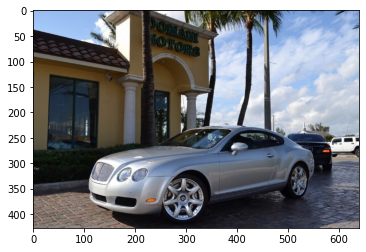

In [6]:
image1 = Image.open('/content/Car Images/Train Images/Bentley Continental GT Coupe 2007/01130.jpg')
imgplot = plt.imshow(image1)
plt.show()

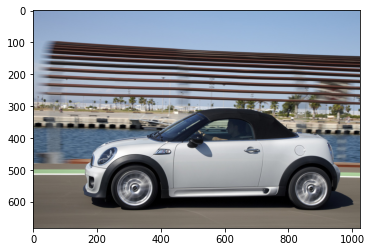

In [7]:
image2 = Image.open('/content/Car Images/Train Images/MINI Cooper Roadster Convertible 2012/03369.jpg')
imgplot = plt.imshow(image2)
plt.show()

In [8]:
car_df = pd.read_csv('clean_train_data.csv', index_col= 0)
car_df.head()

,file,model_name,class,BBOX_x1,BBOX_y1,BBOX_x2,BBOX_y2,BBOX_h,BBOX_w,year,make,model,type
0,00001.jpg,Audi TTS Coupe 2012,14,39,116,569,375,260,531,2012,Audi,TTS,Coupe
1,00002.jpg,Acura TL Sedan 2012,3,36,116,868,587,472,833,2012,Acura,TL,Sedan
2,00003.jpg,Dodge Dakota Club Cab 2007,91,85,109,601,381,273,517,2007,Dodge,Dakota,Cab
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134,621,393,1484,1096,704,864,2012,Hyundai,Sonata,Sedan
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106,14,36,133,99,64,120,2012,Ford,F-450,Cab


In [9]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8144 entries, 0 to 8143
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        8144 non-null   object
 1   model_name  8144 non-null   object
 2   class       8144 non-null   int64 
 3   BBOX_x1     8144 non-null   int64 
 4   BBOX_y1     8144 non-null   int64 
 5   BBOX_x2     8144 non-null   int64 
 6   BBOX_y2     8144 non-null   int64 
 7   BBOX_h      8144 non-null   int64 
 8   BBOX_w      8144 non-null   int64 
 9   year        8144 non-null   int64 
 10  make        8144 non-null   object
 11  model       8144 non-null   object
 12  type        8144 non-null   object
dtypes: int64(8), object(5)
memory usage: 890.8+ KB


In [10]:
car_df.describe()

,class,BBOX_x1,BBOX_y1,BBOX_x2,BBOX_y2,BBOX_h,BBOX_w,year
count,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000
mean,98.979371,64.906803,108.661223,638.208620,416.431606,308.770383,574.301817,2009.559921
std,56.503148,82.198684,104.551635,410.776734,273.786000,213.463238,375.675050,4.435031
min,1.000000,1.000000,1.000000,76.000000,47.000000,24.000000,74.000000,1991.000000
25%,50.000000,19.000000,42.000000,392.000000,248.000000,174.000000,339.000000,2008.000000
50%,99.000000,39.000000,80.000000,569.000000,360.000000,261.000000,505.000000,2012.000000
75%,148.000000,79.000000,138.250000,746.250000,477.000000,371.000000,660.000000,2012.000000
max,196.000000,1648.000000,1508.000000,5205.000000,3389.000000,2649.000000,4157.000000,2012.000000


In [11]:
makes = car_df['make'].value_counts()
makes[:5]

Chevrolet    905
Dodge        630
Audi         589
BMW          531
Ford         521
Name: make, dtype: int64

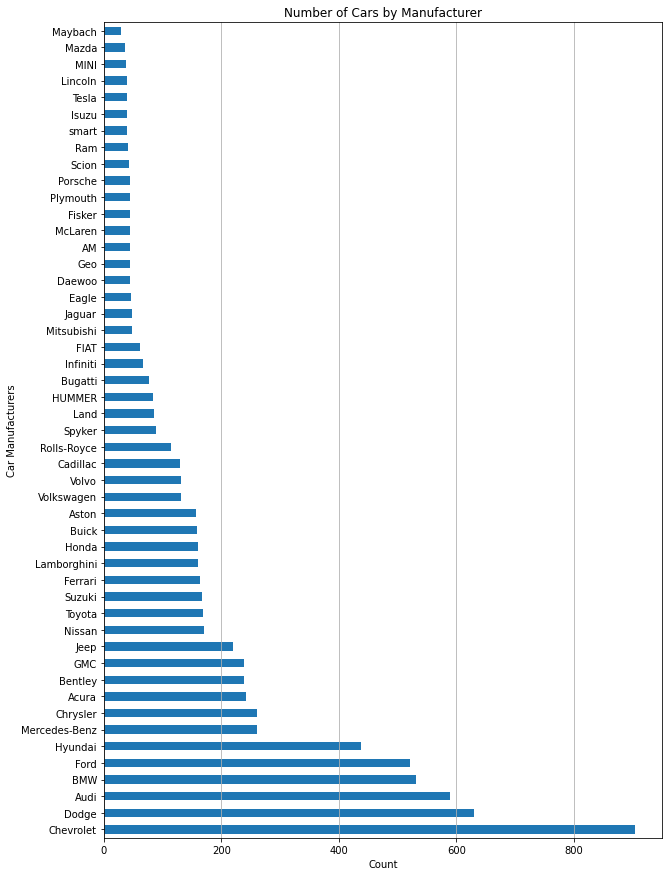

In [12]:
_ = plt.figure(figsize=(10,15))
_ = makes.plot.barh()
_ = plt.title('Number of Cars by Manufacturer')
_ = plt.xlabel('Count')
_ = plt.ylabel('Car Manufacturers')
_ = plt.grid(which= 'major', axis= 'x')
_ = plt.show()

In [13]:
types = car_df['type'].value_counts()
types[:5]

Sedan          1907
SUV            1437
Coupe          1054
Convertible    1036
Cab             719
Name: type, dtype: int64

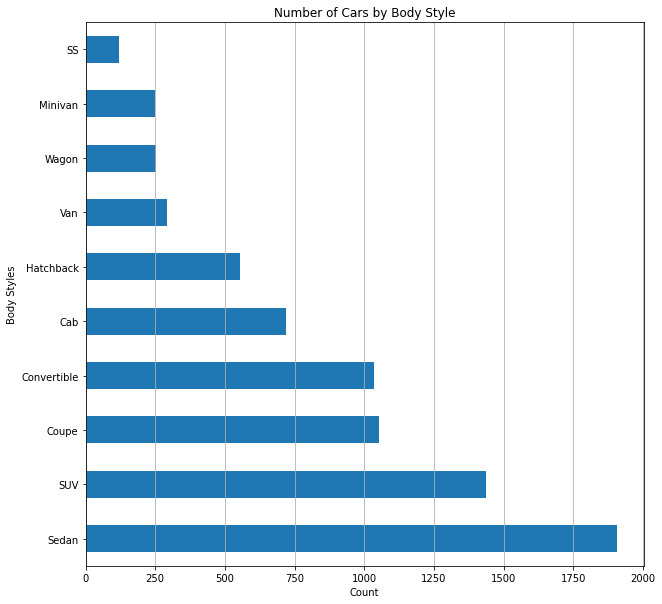

In [14]:
_ = plt.figure(figsize=(10,10))
_ = types[:10].plot.barh()
_ = plt.title('Number of Cars by Body Style')
_ = plt.xlabel('Count')
_ = plt.ylabel('Body Styles')
_ = plt.grid(which= 'major', axis= 'x')
_ = plt.show()

In [15]:
years = car_df['year'].value_counts()
years[:5]

2012    4818
2007    1059
2009     540
2010     413
2011     312
Name: year, dtype: int64

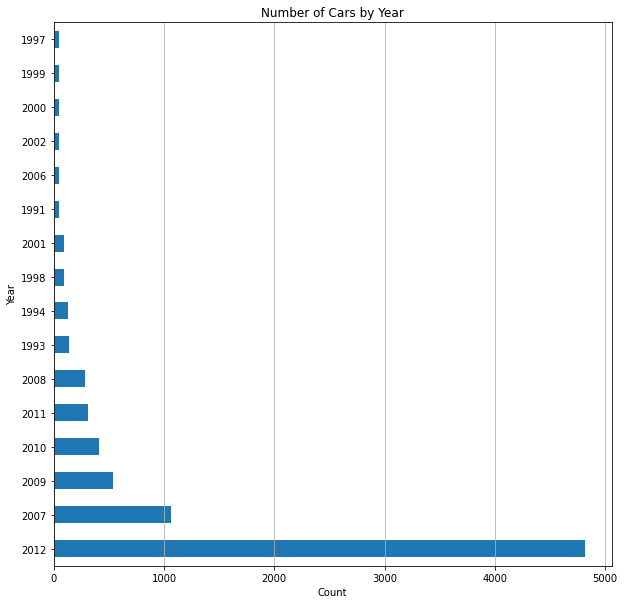

In [16]:
_ = plt.figure(figsize=(10,10))
_ = years.plot.barh()
_ = plt.title('Number of Cars by Year')
_ = plt.xlabel('Count')
_ = plt.ylabel('Year')
_ = plt.grid(which= 'major', axis= 'x')
_ = plt.show()

In [17]:
models = car_df['model_name'].value_counts()
models[:5]

GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mitsubishi Lancer Sedan 2012                48
Mercedes-Benz 300-Class Convertible 1993    48
Jaguar XK XKR 2012                          47
Name: model_name, dtype: int64

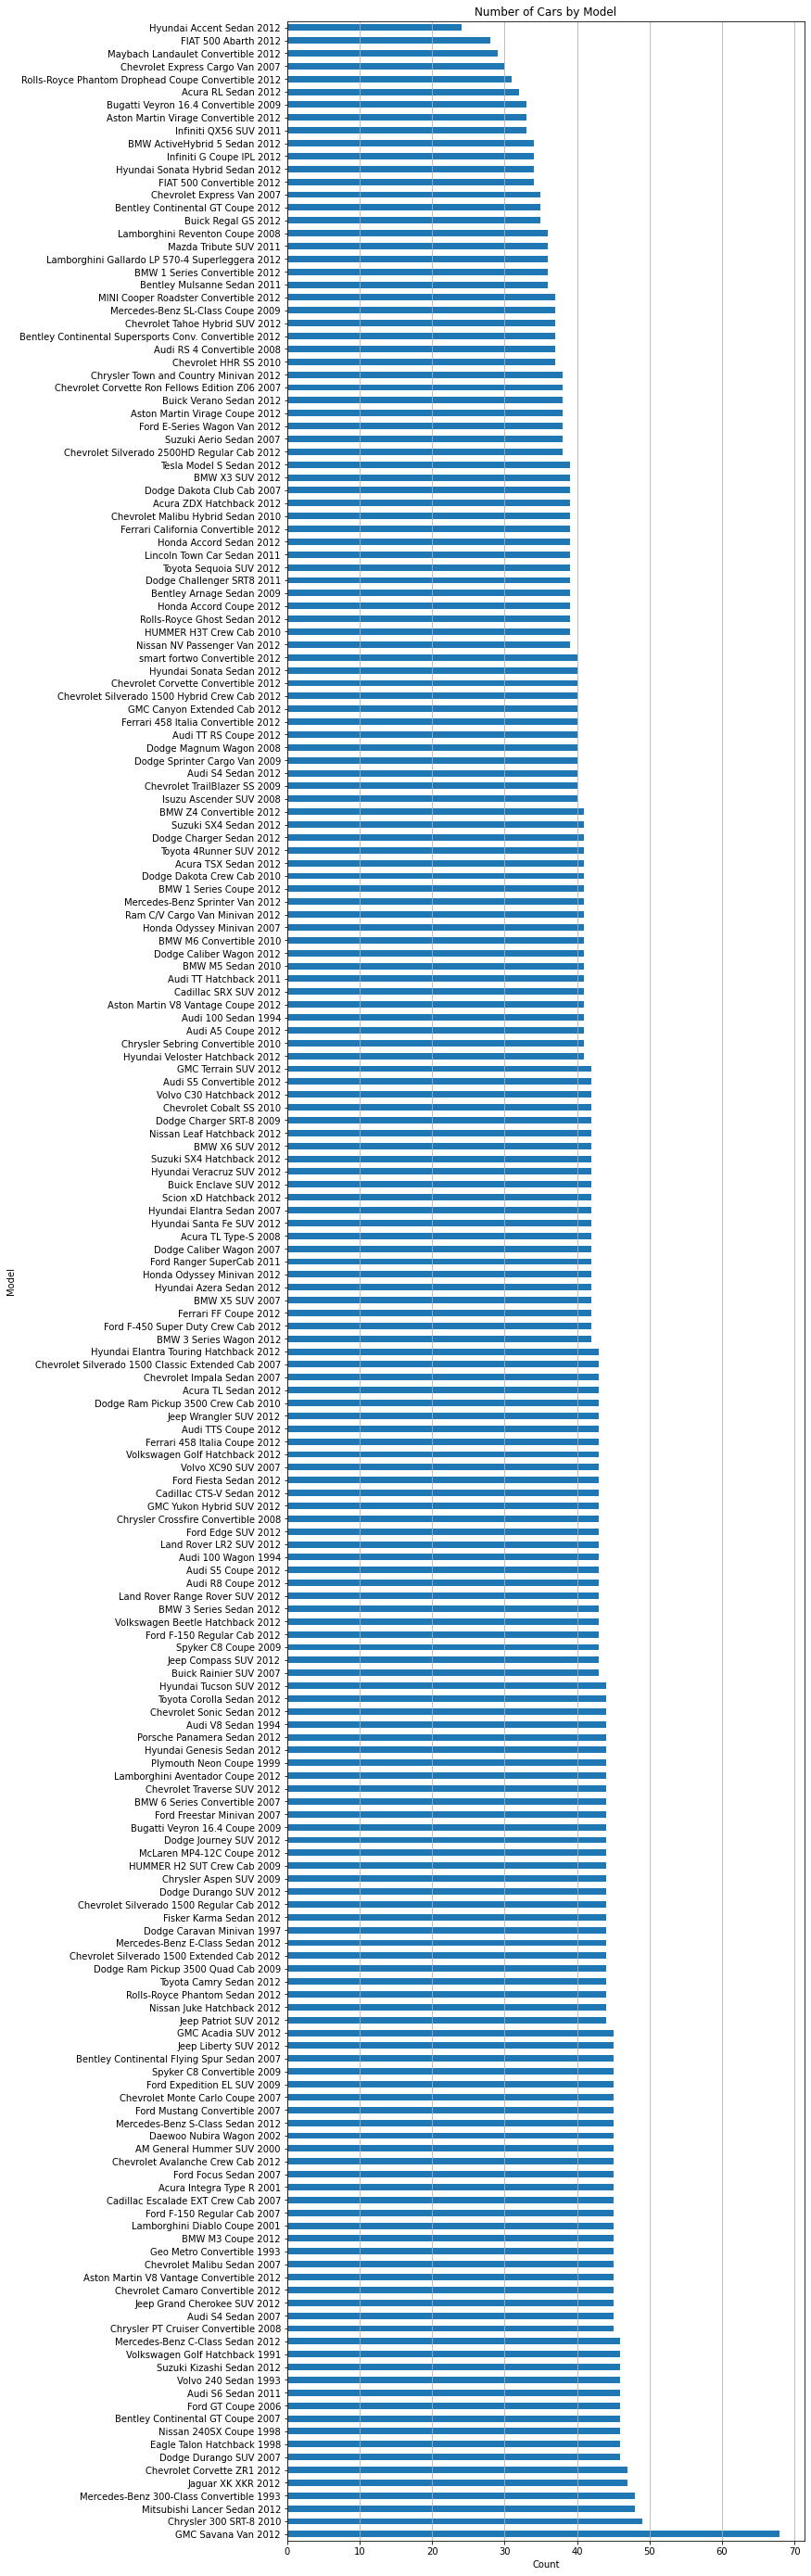

In [18]:
_ = plt.figure(figsize=(10,50))
_ = models.plot.barh()
_ = plt.title('Number of Cars by Model')
_ = plt.xlabel('Count')
_ = plt.ylabel('Model')
_ = plt.grid(which= 'major', axis= 'x')
_ = plt.show()

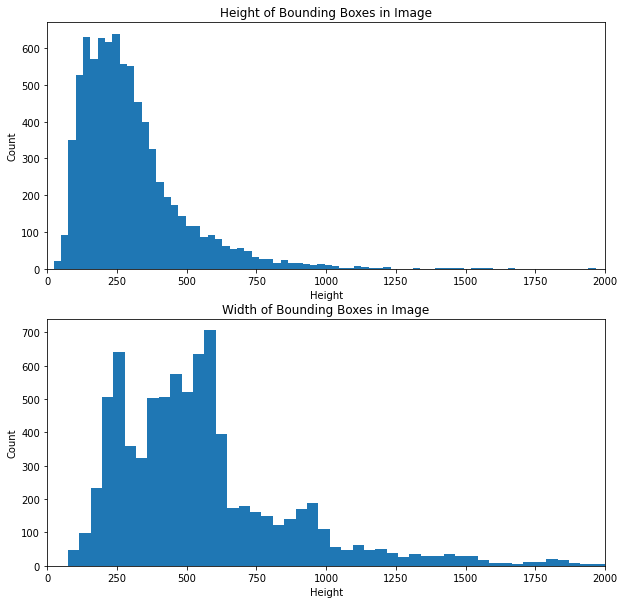

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(car_df.BBOX_h, 100)
ax1.set_title('Height of Bounding Boxes in Image')
ax1.set_xlabel('Height')
ax1.set_ylabel('Count')
ax1.set_xlim(0,2000)
ax2.hist(car_df.BBOX_w, 100)
ax2.set_title('Width of Bounding Boxes in Image')
ax2.set_xlabel('Height')
ax2.set_ylabel('Count')
ax2.set_xlim(0, 2000)
fig.set_size_inches(10, 10)
plt.show()

In [20]:
train_df = pd.read_csv('clean_train_data.csv', index_col= 0)
test_df = pd.read_csv('clean_test_data.csv', index_col= 0)
names_df = pd.read_csv('/content/Car names and make.csv',header= None)
names_df.columns = ['model_name']
names_df.head()

,model_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [21]:
img_width = 299
img_height = 299
num_channels = 3
num_classes = 196
batch_size = 64

train_dir = '/content/Car Images/Train Images'
test_dir = '/content/Car Images/Test Images'
datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range= 40,
                                   width_shift_range= 0.2,
                                   height_shift_range= 0.2,
                                   shear_range= 0.2,
                                   zoom_range= 0.2,
                                   horizontal_flip= True,
                                   fill_mode= 'nearest')

classList = names_df.model_name.tolist()

In [22]:
train_generator = datagen.flow_from_directory(directory= train_dir,
                                            target_size= (img_width,img_height),
                                            classes= classList,
                                            class_mode= 'categorical',
                                            batch_size= batch_size)

train_images_count = len(train_generator.filenames)

Found 8103 images belonging to 196 classes.


In [23]:
test_generator = datagen.flow_from_directory(directory= test_dir,
                                            target_size= (img_width,img_height),
                                            classes= classList,
                                            class_mode= 'categorical',
                                            batch_size= batch_size)

test_images_count = len(train_generator.filenames)

Found 8000 images belonging to 196 classes.


In [24]:
conv_base = tf.keras.applications.inception_v3.InceptionV3(weights= 'imagenet',
                    include_top= False,
                    pooling= 'avg')

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': 196,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dropout(0.5, seed=21))
model.add(Dense(**pred_layer_config))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

model.summary()

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights before freezing the conv base: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
def top_5_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [27]:
optimizer = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_5_acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
history = model.fit_generator(train_generator,
                            steps_per_epoch= 8103 // batch_size,
                            epochs=10,
                            validation_data=test_generator,
                            validation_steps= 8000 // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
126/126 [==============================] - 552s 4s/step - loss: 4.9470 - categorical_accuracy: 0.0452 - top_5_acc: 0.1423 - val_loss: 4.2033 - val_categorical_accuracy: 0.0910 - val_top_5_acc: 0.2788
Epoch 2/10
126/126 [==============================] - 498s 4s/step - loss: 4.1108 - categorical_accuracy: 0.1057 - top_5_acc: 0.3058 - val_loss: 3.8423 - val_categorical_accuracy: 0.1489 - val_top_5_acc: 0.3841
Epoch 3/10
126/126 [==============================] - 493s 4s/step - loss: 3.7575 - categorical_accuracy: 0.1638 - top_5_acc: 0.3976 - val_loss: 3.5996 - val_categorical_accuracy: 0.1863 - val_top_5_acc: 0.4291
Epoch 4/10
126/126 [==============================] - 496s 4s/step - loss: 3.5303 - categorical_accuracy: 0.1887 - top_5_acc: 0.4558 - val_loss: 3.4658 - val_categorical_accuracy: 0.2065 - val_top_5_acc: 0.4751
Epoch 5/10
126/126 [==============================] - 497s 4s/step - loss: 3.3911 - categorical_accuracy: 0.2176 - top_5_acc: 0.4817 - val_loss: 3.4211 - va

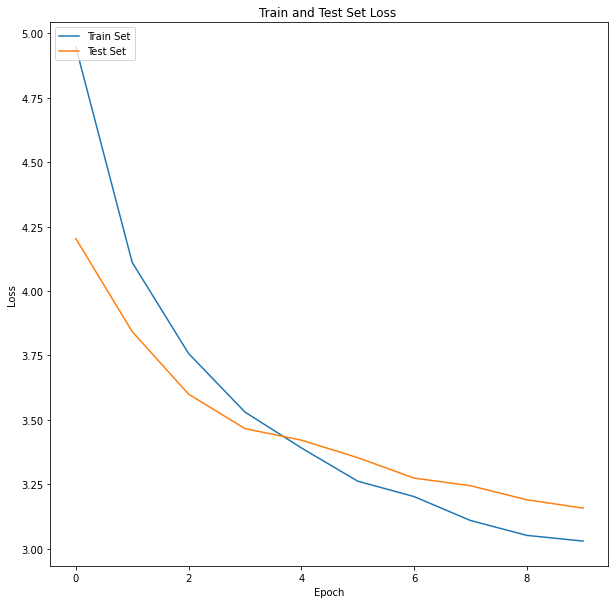

In [29]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['loss'], label='Train Set')
_ = plt.plot(history.history['val_loss'], label='Test Set')
_ = plt.title('Train and Test Set Loss ')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

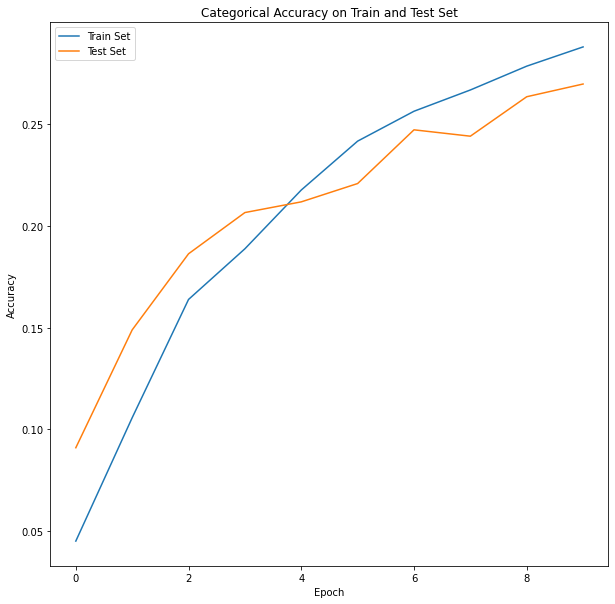

In [30]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['categorical_accuracy'], label='Train Set')
_ = plt.plot(history.history['val_categorical_accuracy'], label='Test Set')
_ = plt.title('Categorical Accuracy on Train and Test Set')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

In [31]:
conv_base.trainable = True
set_trainable = False
layerlist = ['conv2d_71', 'batch_normalization_71',
            'conv2d_72', 'batch_normalization_72',
            'conv2d_73', 'batch_normalization_73',
            'conv2d_74', 'batch_normalization_74',
            'conv2d_75', 'batch_normalization_75',
            'conv2d_76', 'batch_normalization_76'
            'conv2d_77', 'batch_normalization_77',
            'conv2d_78', 'batch_normalization_78',
            'conv2d_79', 'batch_normalization_79',
            'conv2d_80', 'batch_normalization_80',
            'conv2d_81', 'batch_normalization_81',
            'conv2d_82', 'batch_normalization_82',
            'conv2d_83', 'batch_normalization_83',
            'conv2d_84', 'batch_normalization_84',
            'conv2d_85', 'batch_normalization_85'
            'conv2d_86', 'batch_normalization_86',
            'conv2d_87', 'batch_normalization_86',
            'conv2d_88', 'batch_normalization_88',
            'conv2d_89', 'batch_normalization_89',
            'conv2d_90', 'batch_normalization_90',
            'conv2d_91', 'batch_normalization_90',
            'conv2d_92', 'batch_normalization_92',
            'conv2d_93', 'batch_normalization_93',
            'conv2d_94', 'batch_normalization_94']

for layer in conv_base.layers:
    if layer.name in layerlist:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
        
    else:
        layer.trainable = False

print('This is the number of trainable weights after limited freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after limited freezing the conv base: 50


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 13,213,508
Non-trainable params: 8,990,880
_________________________________________________________________


In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_5_acc])

history = model.fit_generator(train_generator,
                            steps_per_epoch= 8103 // batch_size,
                            epochs= 15,
                            validation_data=test_generator,
                            validation_steps= 8000 // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
126/126 [==============================] - 509s 4s/step - loss: 4.2596 - categorical_accuracy: 0.0886 - top_5_acc: 0.2592 - val_loss: 3.4718 - val_categorical_accuracy: 0.1680 - val_top_5_acc: 0.4595
Epoch 2/15
126/126 [==============================] - 492s 4s/step - loss: 2.5773 - categorical_accuracy: 0.3278 - top_5_acc: 0.6687 - val_loss: 2.3850 - val_categorical_accuracy: 0.3795 - val_top_5_acc: 0.7272
Epoch 3/15
126/126 [==============================] - 495s 4s/step - loss: 1.8179 - categorical_accuracy: 0.4958 - top_5_acc: 0.8203 - val_loss: 1.8167 - val_categorical_accuracy: 0.5121 - val_top_5_acc: 0.8195
Epoch 4/15
126/126 [==============================] - 499s 4s/step - loss: 1.3866 - categorical_accuracy: 0.6004 - top_5_acc: 0.8919 - val_loss: 1.5514 - val_categorical_accuracy: 0.5725 - val_top_5_acc: 0.8590
Epoch 5/15
126/126 [==============================] - 495s 4s/step - loss: 1.1377 - categorical_accuracy: 0.6666 - top_5_acc: 0.9237 - val_loss: 1.4342 - va

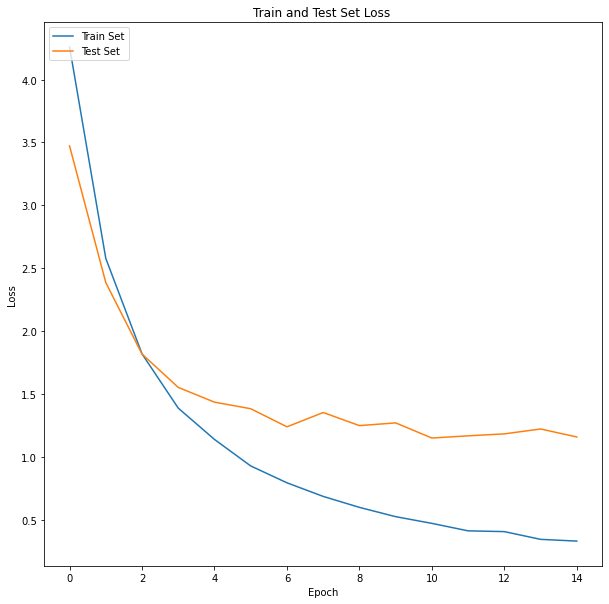

In [34]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['loss'], label='Train Set')
_ = plt.plot(history.history['val_loss'], label='Test Set')
_ = plt.title('Train and Test Set Loss ')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

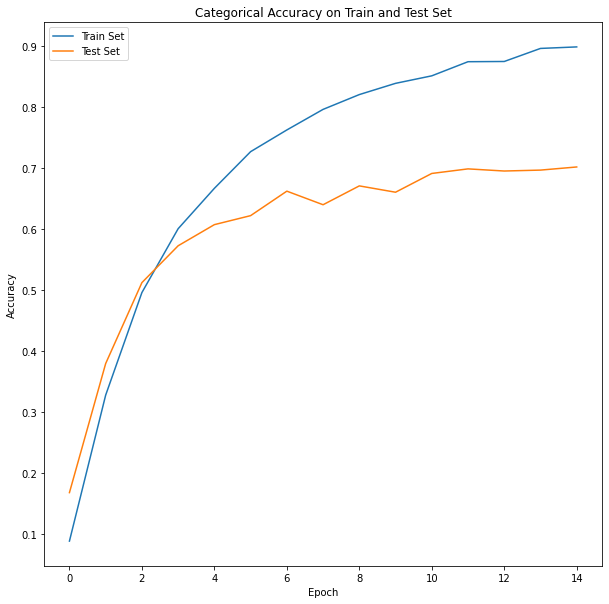

In [35]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['categorical_accuracy'], label='Train Set')
_ = plt.plot(history.history['val_categorical_accuracy'], label='Test Set')
_ = plt.title('Categorical Accuracy on Train and Test Set')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

### Pickling the model 

In [ ]:
json_model = model.to_json()
with open('inceptionv2.json', 'w') as json_file:
    json.dump(json_model,json_file)

  ### Clickable  UI

In [ ]:
import tkinter as tk 
from tkinter import ttk 
  
from tkinter import * 
from tkinter import filedialog as fd 
from tkinter import messagebox as ms 
from PIL import ImageTk, Image 

 
class Image_Viewer: 
    
    def __init__(self,master): 
        self.master = master 
        self.c_size = (700,500) 
        self.setup_gui(self.c_size) 
        self.img=None 
    
    def setup_gui(self,s): 
        Label(self.master,text='Image Viewer',pady=5,bg='white', font=('Arial',30)).pack() 
        self.canvas = Canvas(self.master,height=s[1],width=s[0], bg='Black',bd=10,relief='ridge')
        self.canvas.pack() 
       
        self.wt = self.canvas.create_text(s[0]/2-270,s[1]/2,text=txt ,font=('',30),fill='white') 
        f=Frame(self.master,bg='white',padx=10,pady=10) 
        Button(f,text='Open Image',bd=2,fg='white',bg='black',font=('',15) ,command=self.make_image).pack(side=LEFT) 
        f.pack() 
    def make_image(self):   
        
        try: 
            File = fd.askopenfilename() 
            self.pilImage = Image.open(File) 
            re=self.pilImage.resize((700,500),Image.ANTIALIAS) 
            self.img = ImageTk.PhotoImage(re) 
            self.canvas.delete(ALL) 
            self.canvas.create_image(self.c_size[0]/2+10,self.c_size[1]/2+10, anchor=CENTER,image=self.img) 
            self.status['text']='Current Image:'+File 
        
        except: 
            ms.showerror('Error!','File type is unsupported.') 
root=Tk() 
root.configure(bg='white') 
root.title('Image Viewer') 
Image_Viewer(root) 
root.resizable(0,0) 
root.mainloop()
window.mainloop() 